In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Position estimation with KF

The initial position, $x_0$, of a vehicle is inexactly known: $x_0 \sim \mathcal{N}(0, 100).$ The velocity of the vehicle, $u_t$, is approximately $10$ m/s in the following sense $u_t \sim \mathcal{N}(10, 8).$

The position of the vehicle can be measured (e.g., using GPS) every $h=0.05$s using a sensor with additive noise $v_t\sim\mathcal{N}(0, 15)$.

The dynamics of the position of the vehicle is
$$\begin{align*}
        x_{t+1} {}={} & x_t + hu_t,
        \\
        y_t {}={}     & x_t + v_t.
\end{align*}$$
**However:** $u_t$ is *not* a zero-mean random variable!

The velocity can be written as
$$u_t = \bar{u}_t + w_t,$$
where $\bar{u}_t = 10$m/s and $w_t \sim \mathcal{N}(0, 8)$. Since $\bar{u}_t$ is constant, $\bar{u}_{t+1} = \bar{u}_t$, so
$$\underbracket[0.5pt]{\begin{bmatrix}
            x_{t+1} \\ \bar{u}_{t+1}
        \end{bmatrix}}_{z_{t+1}}
        {}={}
        \underbracket[0.5pt]{
            \begin{bmatrix}
                1 & h
                \\
                0 & 1
            \end{bmatrix}
        }_{A}
        \cdot
        \underbracket[0.5pt]{
            \begin{bmatrix}
                x_{t} \\ \bar{u}_{t}
            \end{bmatrix}
        }_{z_t}
        +
        \underbracket[0.5pt]{
            \begin{bmatrix}
                h \\0
            \end{bmatrix}
        }_{G}
        w_t.$$
The state of the system is $z_t = (x_t, \bar{u}_t)$ with
$$z_0 \sim \mathcal{N}\left(\begin{bmatrix}0\\10\end{bmatrix},\begin{bmatrix}1000 & 0\\0 & 0\end{bmatrix}\right).$$
The output of the system is
$$y_t = \begin{bmatrix}1 & 0\end{bmatrix}z_t + v_t.$$

In [26]:
# Problem data
h = 0.05
A = np.array([[1, h], [0, 1]])
G = np.array([[h], [0]])
C = np.array([[1, 0]])
P0 = np.array([[1000, 0], [0, 0]])
x0_tilde = np.array([[0], [10]])
Q = 8
R = 15

In [54]:
# Measurement and Time update functions

def measurement_update(sigma_tu, x_tu, y):
    z = C @ sigma_tu @ C.T + R # auxiliary variable
    x_mu = x_tu + sigma_tu @ C.T @ np.linalg.solve(z, y - C@x_tu)
    sigma_mu = sigma_tu - sigma_tu @ C.T @ np.linalg.solve(z, C@sigma_tu)
    return sigma_mu, x_mu

def time_update(sigma_mu, x_mu):
    x_tu = A @ x_mu
    sigma_tu = A @ sigma_mu @ A.T + Q * (G @ G.T)
    return sigma_tu, x_tu

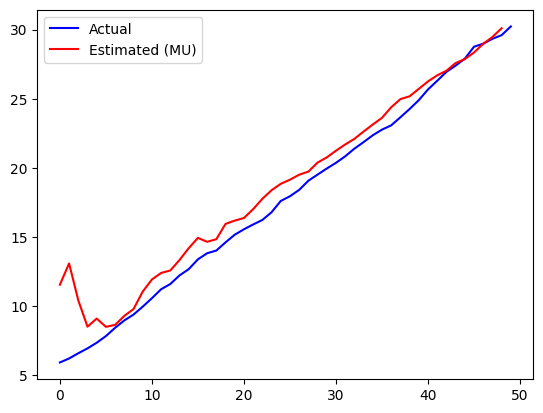

In [62]:
# Implementation of KF
x = np.random.multivariate_normal(x0_tilde.flatten(), P0, 1).reshape((-1,1)) # random initial state
sigma_tu, x_tu = P0, x0_tilde.reshape((-1, 1)) # initialisation

n_sim = 50
x_cache = np.zeros((n_sim, 2))
x_mu_cache = np.zeros((n_sim-1, 2))
x_cache[0, :] = x.T
for t in range(n_sim - 1):
    v = np.random.normal(0, np.sqrt(R), 1)
    y = C @ x + v
    sigma_mu, x_mu = measurement_update(sigma_tu, x_tu, y)
    x_mu_cache[t, :] = x_mu.T
    sigma_tu, x_tu = time_update(sigma_mu, x_mu)
    w = np.random.normal(0, np.sqrt(Q), 1).T
    x = A @ x + G * w
    x_cache[t+1, :] = x.T

plt.plot(x_cache[:, 0], 'b-', label='Actual')
plt.plot(x_mu_cache[:, 0], 'r-', label='Estimated (MU)')
plt.legend()
plt.show()